In [63]:
import torch
import torchvision as tv
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

In [64]:
class ImgFolder(tv.datasets.ImageFolder):
    def __getitem__(self, index):
        origin_data = process(self.imgs[data])
        transform_data = transform(origin_data)
        return origin_data, transform_data, label

In [65]:
transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))]
)

dataset = tv.datasets.ImageFolder("./mini_data", transform=transform)
trainset, testset = torch.utils.data.random_split(dataset, [20, 8])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=2, shuffle=True, num_workers=1)
testloader = torch.utils.data.DataLoader(testset, batch_size=2, shuffle=False, num_workers=1)

classes = ("elsa", "not_elsa")

In [66]:
def imshow(img):
    img = img/2+0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

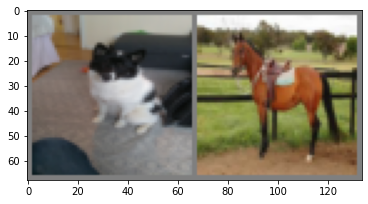

 elsa not_elsa


In [67]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(tv.utils.make_grid(images))
print(' '.join("%5s" % classes[labels[j]] for j in range(2)))

In [68]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3,6,5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6,16,5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(4096,1024)
        self.fc2 = nn.Linear(1024, 2)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training = self.training)
        x = self.fc2(x)
        return x

In [69]:
net = Net()

In [70]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [72]:
for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        print(inputs.shape)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        print("[%d, %5d] loss: %.3f" % (epoch + 1, i + 1, running_loss))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (2x2704 and 4096x1024)